In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import torch

import random

import numpy as np
import torch


def set_seed(seed):
    """Set all seeds for reproducibility"""
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # PyTorch multi-GPU
    torch.backends.cudnn.deterministic = True  # CUDNN
    torch.backends.cudnn.benchmark = False  # CUDNN


set_seed(42)

## True dynamics

In [2]:
def ode(X, t, zeta=0.05, omega0=1.0, force=0.0):
    """
    Forced damped Harmonic Oscillator ODE
    """
    x, v = X
    dv = -2 * zeta * omega0 * v - omega0**2 * x + force
    return [v, dv]


def rk4_single_step(f, X0, t, **kwargs):
    """
    Fourth-order Runge-Kutta method for solving ODEs

    """
    assert len(t) == 2, "t must have two elements"
    dt = t[1] - t[0]
    assert dt > 0, "t must be increasing"

    k1 = f(X0, t[0], **kwargs)
    k2 = f(X0 + 0.5 * dt * np.array(k1), t[0] + 0.5 * dt, **kwargs)
    k3 = f(X0 + 0.5 * dt * np.array(k2), t[0] + 0.5 * dt, **kwargs)
    k4 = f(X0 + dt * np.array(k3), t[1], **kwargs)
    X = X0 + (dt / 6) * (
        np.array(k1) + 2 * np.array(k2) + 2 * np.array(k3) + np.array(k4)
    )

    return X

## Learnt dynamics

In [3]:
# Define a simple MLP (Multi-Layer Perceptron) for Harmonic Oscillator
class HarmonicMLP(torch.nn.Module):
    def __init__(self, input_size=3, hidden_size=1024, output_size=2, num_layers=4):
        super(HarmonicMLP, self).__init__()

        # Input layer
        layers = [torch.nn.Linear(input_size, hidden_size), torch.nn.GELU()]

        # Hidden layers
        for _ in range(num_layers - 2):
            layers.extend([torch.nn.Linear(hidden_size, hidden_size), torch.nn.GELU()])

        # Output layer
        layers.append(torch.nn.Linear(hidden_size, output_size))

        # Sequential container
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return x[:, :2] + self.model(x)


model = HarmonicMLP()
model_save_path = "best_model.pth"
model.load_state_dict(torch.load(model_save_path, map_location="cpu"))
model.eval()

HarmonicMLP(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=1024, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=1024, out_features=2, bias=True)
  )
)

## Control task

In [64]:
class PID:
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.integral = 0
        self.previous_error = 0

    def __call__(self, reference, x, dt):
        error = reference - x
        self.integral += error * dt
        derivative = (error - self.previous_error) / dt
        self.previous_error = error
        return self.kp * error + self.ki * self.integral + self.kd * derivative


def eval_model_with_controller(f, controller, reference, X0, n, dt):
    """
    Evaluate the model with a PID controller
    """
    X = np.zeros((n, 2))
    forces = np.zeros((n, 1))
    X[0] = X0
    for i in range(1, n):
        u = controller(reference=reference[i], x=X[i - 1][0], dt=dt)
        z = np.stack([X[i - 1][0], X[i - 1][1], u], axis=0)
        X[i] = f(z)
        forces[i] = u

    return X, forces

In [ ]:
controller = PID(-0.5, 0.05, 0.9)
model_X, model_forces = eval_model_with_controller(
    f=lambda z: model.forward(torch.tensor(z, dtype=torch.float32).reshape(1, 3))
    .detach()
    .numpy(),
    controller=controller,
    X0=np.array([1.0, 0.0]),
    n=10_000,
    dt=0.01,
    reference=np.ones(10_000),
)

In [80]:
controller = PID(-0.5, 0.05, 0.9)
true_X, true_forces = eval_model_with_controller(
    f=lambda z: rk4_single_step(
        ode,
        z[:-1],
        t=[0, 0.01],
        force=z[-1],
    ),
    controller=controller,
    X0=np.array([1.0, 0.0]),
    n=10_000,
    dt=0.01,
    reference=np.ones(10_000),
)

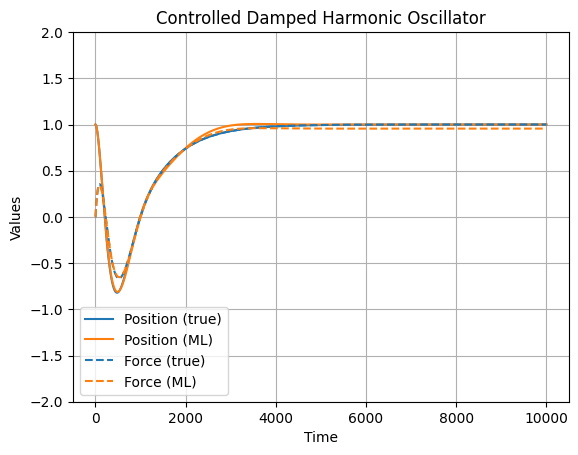

In [81]:
plt.plot(true_X[:, 0], label="Position (true)", color="C0")
plt.plot(model_X[:, 0], label="Position (ML)", color="C1")
plt.plot(true_forces, label="Force (true)", linestyle="--", color="C0")
plt.plot(model_forces, label="Force (ML)", linestyle="--", color="C1")
plt.xlabel("Time")
plt.ylabel("Values")
plt.title("Controlled Damped Harmonic Oscillator")
plt.legend()
plt.grid()
plt.ylim(-2, 2)
plt.show()